# Assignment 8 – LLM Evaluation on IMDb Sentiment

This notebook fine-tunes a DistilBERT model on the IMDb movie review dataset
and then evaluates it using:

- Accuracy
- Macro Precision
- Macro Recall
- Macro F1

It also generates a normalized confusion matrix and performs error analysis on
the worst performing class.

In [1]:
# In this cell I import everything I need for evaluation.
# I use the same libraries as Assignment 7 plus sklearn for metrics.

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from peft import PeftModel
import torch
import numpy as np

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)

import matplotlib.pyplot as plt


In [2]:
# In this cell I load the IMDb dataset again.
# This keeps Assignment 8 consistent with Assignment 7.

dataset = load_dataset("imdb")

# I reuse the same label mapping as before.
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
label_names = ["negative", "positive"]

In [3]:
# In this cell I load the fine tuned LoRA DistilBERT model I saved in Assignment 7.
# The folder name must match what I used when I called save_model.

model_path = "lora_distilbert_imdb_finetuned"
base_model_name = "distilbert-base-uncased"

# I load the tokenizer from the saved folder.
tokenizer = AutoTokenizer.from_pretrained(model_path)

# I load the original DistilBERT classifier.
base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

# I attach the LoRA weights that I fine tuned in Assignment 7.
model = PeftModel.from_pretrained(base_model, model_path)

# I put the model on CPU or GPU depending on what is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded fine tuned LoRA model from:", model_path)
print("Using device:", device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded fine tuned LoRA model from: lora_distilbert_imdb_finetuned
Using device: cpu


In [4]:
# In this cell I tokenize the IMDb dataset the same way I did in Assignment 7.

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# I rename the label column to 'labels' for transformers.
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# I keep only the columns that the model needs.
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)

# I keep the original train/val/test idea from Assignment 7.
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2)
train_dataset = train_val_split["train"]
eval_dataset = train_val_split["test"]
test_dataset = tokenized_datasets["test"]

len(train_dataset), len(eval_dataset), len(test_dataset)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

(20000, 5000, 25000)

In [5]:
# In this cell I build a DataLoader for the test set.
# This lets me run the model in batches and collect predictions.

from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=data_collator,
)

len(test_loader)

782

In [6]:
# In this cell I run my fine tuned model on the held out test set.
# I collect all true labels and predicted labels so I can compute metrics.

model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        # move batch to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_labels.extend(batch["labels"].cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

len(all_labels), len(all_preds)


(25000, 25000)

In [7]:
# In this cell I calculate the main four metrics.
# I store them in variables so I can reuse them in my README and my video.

accuracy = accuracy_score(all_labels, all_preds)

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average="macro"
)

print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")
print(f"Macro F1:        {f1_macro:.4f}")


Accuracy:        0.9219
Macro Precision: 0.9221
Macro Recall:    0.9219
Macro F1:        0.9219


In [8]:
# In this cell I look at precision, recall, and F1 for each class.
# This helps me find which class my model struggles with the most.

precision_per, recall_per, f1_per, support_per = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average=None,
    labels=[0, 1]
)

for idx, name in enumerate(label_names):
    print(f"Class: {name}")
    print(f"  Precision: {precision_per[idx]:.4f}")
    print(f"  Recall:    {recall_per[idx]:.4f}")
    print(f"  F1:        {f1_per[idx]:.4f}")
    print(f"  Support:   {support_per[idx]}")
    print()

worst_class_index = int(np.argmin(f1_per))
worst_class_name = label_names[worst_class_index]

print("Worst class by F1 score:", worst_class_index, "-", worst_class_name)


Class: negative
  Precision: 0.9302
  Recall:    0.9123
  F1:        0.9212
  Support:   12500

Class: positive
  Precision: 0.9140
  Recall:    0.9315
  F1:        0.9227
  Support:   12500

Worst class by F1 score: 0 - negative


In [9]:
# In this cell I build a normalized confusion matrix.
# Each row sums to 1, so the numbers are easy to read as percentages.

cm = confusion_matrix(
    all_labels,
    all_preds,
    labels=[0, 1],
    normalize="true"
)

cm


array([[0.91232, 0.08768],
       [0.06848, 0.93152]])

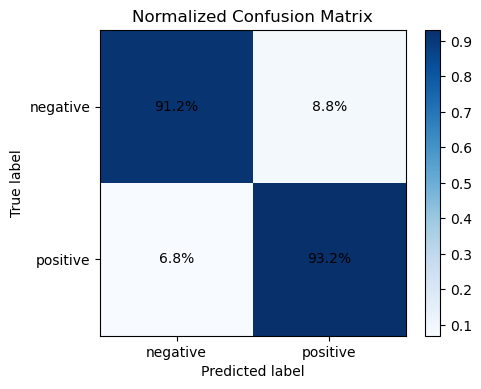

In [10]:
# In this cell I plot the confusion matrix and save it as an image.
# This PNG file will go into my GitHub repo.

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.colorbar()

classes = ["negative", "positive"]
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes)

# I print each cell as a percentage inside the matrix.
for i in range(2):
    for j in range(2):
        plt.text(
            j, i,
            f"{cm[i, j]*100:.1f}%",
            ha="center", va="center"
        )

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


In [11]:
# In this cell I find misclassified reviews that belong to the worst class.
# I will use two of them for my error analysis.

misclassified_indices = []

for i in range(len(all_labels)):
    if all_labels[i] == worst_class_index and all_preds[i] != all_labels[i]:
        misclassified_indices.append(i)

print("Total misclassified from worst class:", len(misclassified_indices))
misclassified_indices[:10]


Total misclassified from worst class: 1096


[4, 6, 18, 20, 27, 32, 37, 46, 55, 61]

In [12]:
# In this cell I print two misclassified reviews from the worst class.
# I will describe these in my README and in my video.

test_raw = dataset["test"]

for k, idx in enumerate(misclassified_indices[:2], start=1):
    print("=" * 80)
    print(f"Example {k}")
    print("True label:     ", label_names[all_labels[idx]])
    print("Predicted label:", label_names[all_preds[idx]])
    print("\nText:\n")
    print(test_raw[idx]["text"])
    print("\n")


Example 1
True label:      negative
Predicted label: positive

Text:

First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!


Example 2
True label:      negative
Predicted label: positive

Text:

Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action class